# Sentence BERT clustering demo

This notebook will showcase a quick demo for how our clustering system works behind the scenes. A potential use case can then be seen in our web app demo.

In [2]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE

from transformers import AutoTokenizer, GPT2LMHeadModel
# from bertopic import BERTopic
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# from bertopic.vectorizers import ClassTfidfTransformer
from ctfidf import ClassTfidfTransformer

/home/merlo/anaconda3/envs/NLP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fetch news dataset

The initial idea behind this project is to cluster notes based on their content, which could for example be useful in note-taking apps like Notion or Obsidian. Due to the lack of available datasets, this demo will use a news dataset instead, which we find to be similar enough to notes for this purpose (small to medium length, with texts about a variety of recognizable topics like science or sports).

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
idxs = [ i for i in range(len(newsgroups_train.data)) if len(newsgroups_train.data[i]) > 20 ]
newsgroups_train.data = [ newsgroups_train.data[i] for i in idxs ]
newsgroups_train.target = [ newsgroups_train.target[i] for i in idxs ]

In [4]:
docs = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))['data']

In [5]:
print("Train data size: ", len(newsgroups_train.data))

print("Average train data length: ", np.mean([len(x.split()) for x in newsgroups_train.data]))

print("Train data labels: ", newsgroups_train.target_names)
print("Number of train data labels: ", len(newsgroups_train.target_names))

print(f"Example:\n[{newsgroups_train.target_names[newsgroups_train.target[0]]}] ", newsgroups_train.data[0])

Train data size:  10955
Average train data length:  191.90652670013694
Train data labels:  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Number of train data labels:  20
Example:
[rec.autos]  I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car,

## Generate sentence embeddings

We use the [SentenceBERT](https://sbert.net/index.html) project implementation of a Sentence Transformer to generate sentence embeddings. We tested a variety of different models from their collection, which all seem to yield similar results. The embedding is a 384-dimensional vector for every article.

In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')
train_embeddings = model.encode(newsgroups_train.data, show_progress_bar=True)
train_embeddings.shape

Batches: 100%|██████████| 343/343 [00:19<00:00, 17.54it/s]


(10955, 384)

## Cluster the embeddings

We then use a simple implementation of KMeans to cluster the embeddings together, which could be useful for grouping similar notes together. The number of clusters is set to 20, in this case, since we know the dataset had 20 categories. On our web demo we implemented a variable number of clusters, which acts as a different "zoom level" into the dataset.

In [16]:
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto').fit(train_embeddings)
agg = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward').fit(train_embeddings)
spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors').fit(train_embeddings)

clustering = spectral


/home/merlo/anaconda3/envs/NLP/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


## Create the graph using tSNE

We perform dimensionality reduction on the embeddings with t-SNE to be able to plot them.

In [8]:
tsne = TSNE(n_components=2, n_iter=1000, n_iter_without_progress=200, perplexity=35)
print(train_embeddings.shape)
tsne_embeddings = tsne.fit_transform(train_embeddings)

(10955, 384)


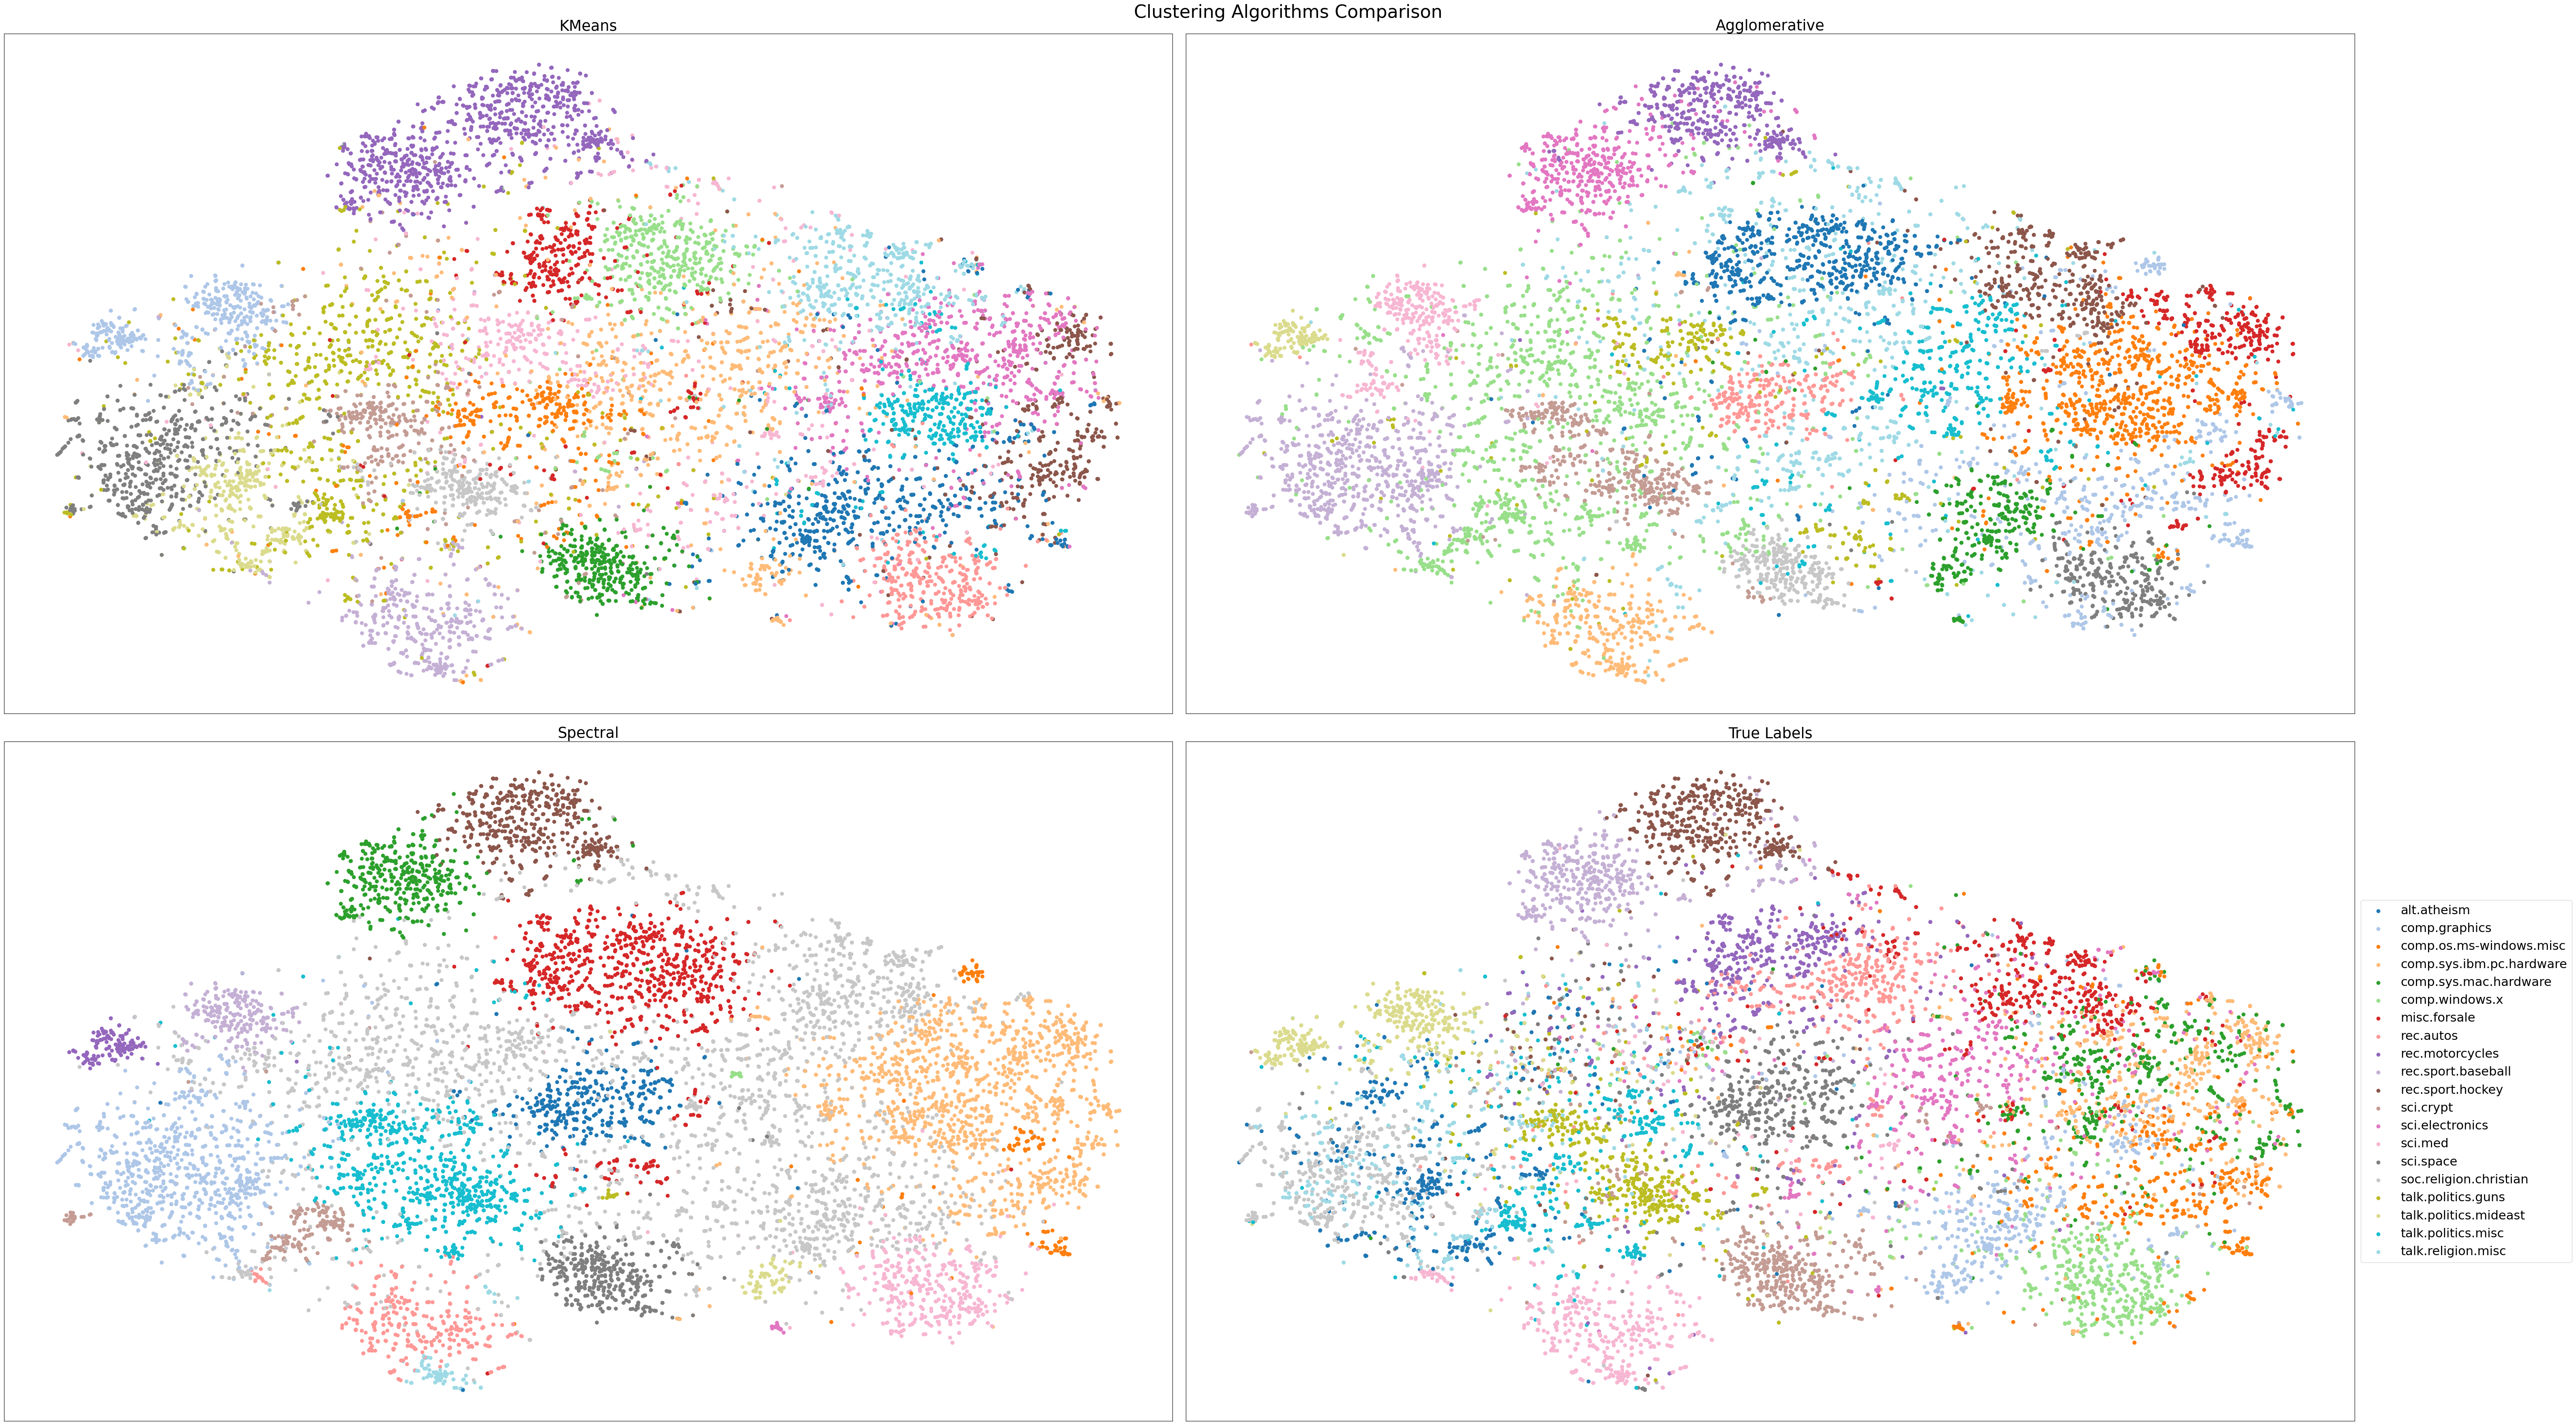

In [9]:
plt.figure(figsize=(16*4, 9*4))
plt.rcParams.update({'font.size': 22})
plt.subplot(2, 2, 1)
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=kmeans.labels_, cmap='tab20')
plt.xticks([])
plt.yticks([])
plt.title("KMeans")

plt.subplot(2, 2, 2)
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=agg.labels_, cmap='tab20')
plt.xticks([])
plt.yticks([])
plt.title("Agglomerative")

plt.subplot(2, 2, 3)
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=spectral.labels_, cmap='tab20')
plt.xticks([])
plt.yticks([])
plt.title("Spectral")

plt.subplot(2, 2, 4)
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=newsgroups_train.target, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=newsgroups_train.target_names[i]) for i in range(20)], loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([])
plt.yticks([])
plt.title("True Labels")

plt.suptitle("Clustering Algorithms Comparison", fontsize=32)
plt.tight_layout()

plt.rcParams.update({'font.size': 10})

We can see comparing the original labels (on the bottom) with the computed clusters (on the top) that the clustering algorithm did a pretty good job at grouping similar articles together, and finds clusters that are similar to the original dataset. This means that the embedding worked well enough to separate different articles and group similar ones together in the vector space.

## Cluster labelling

To generate topics that can act as labels for our clusters, we use Latent Dirichlet Allocation (LDA) on the original dataset. This is a common technique used in topic modelling, which we can use to generate a list of topics for each cluster. We then use the most common topic for each cluster as its label. A topic is a list of 5 words that somehow represent the cluster.

In [17]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

X = np.empty(num_clusters, dtype=object)
for i in range(num_clusters):
    X[i] = '\n'.join([newsgroups_train.data[j] for j in range(len(newsgroups_train.data)) if clustering.labels_[j] == i])

vectorizer = CountVectorizer(
    max_df=0.8,
    min_df=0.2,
    max_features=100000,
    stop_words="english",
    preprocessor=preprocess
)

ctfidf_model = ClassTfidfTransformer()

X = vectorizer.fit_transform(X)
X = ctfidf_model.fit_transform(X).todense()

features, tfidf_sort = np.array(vectorizer.get_feature_names_out()), np.argsort(X)

num_keywords = 20
top_n = features[tfidf_sort][:,-num_keywords:].tolist()
top_n = [kw[::-1] for kw in top_n]
keywords = {i: top_n[i] for i in range(len(top_n))}

print("Keywords of clusters are:\n")
for n in range(len(keywords)):
    print("Cluster %s: %s" % (n, keywords[n]))

Keywords of clusters are:

Cluster 0: ['gay', 'morality', 'moral', 'sex', 'objective', 'homosexual', 'marriage', 'homosexuals', 'sexual', 'men', 'married', 'gays', 'immoral', 'god', 'society', 'orientation', 'church', 'hudson', 'love', 'person']
Cluster 1: ['file', 'image', 'software', 'ftp', 'graphics', 'output', 'files', 'send', 'package', 'entry', 'data', 'version', 'jpeg', 'president', 'windows', 'pub', 'format', 'space', 'dos', 'images']
Cluster 2: ['car', 'bike', 'cars', 'engine', 'miles', 'ride', 'oil', 'mph', 'speed', 'tires', 'riding', 'helmet', 'rear', 'driving', 'dealer', 'motorcycle', 'dog', 'bmw', 'ford', 'insurance']
Cluster 3: ['ground', 'grounding', 'neutral', 'conductor', 'wire', 'connected', 'panel', 'grounded', 'outlets', 'breaker', 'metal', 'equipment', 'wiring', 'flow', 'circuit', 'green', 'entrance', 'load', 'exceptions', 'seperate']
Cluster 4: ['medical', 'patients', 'health', 'cancer', 'doctor', 'disease', 'pain', 'medicine', 'treatment', 'aids', 'gordon', 'geb'

## Obtaining a 1-word summary of the keywords
It does not work well for now, we could perhaps improve it by training a model on (doc, topic) pairs comming from the intial dataset.

In [20]:
tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
model = GPT2LMHeadModel.from_pretrained('gpt2-large')

query = f"A single word to define the topic given by the keywords [{', '.join(keywords[2])}] is: "
inputs = tokenizer(query, return_tensors='pt').input_ids
outputs = model.generate(inputs, max_new_tokens=10, do_sample=False)
label = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(label[len(query):])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 "car"
The keyword "bike"


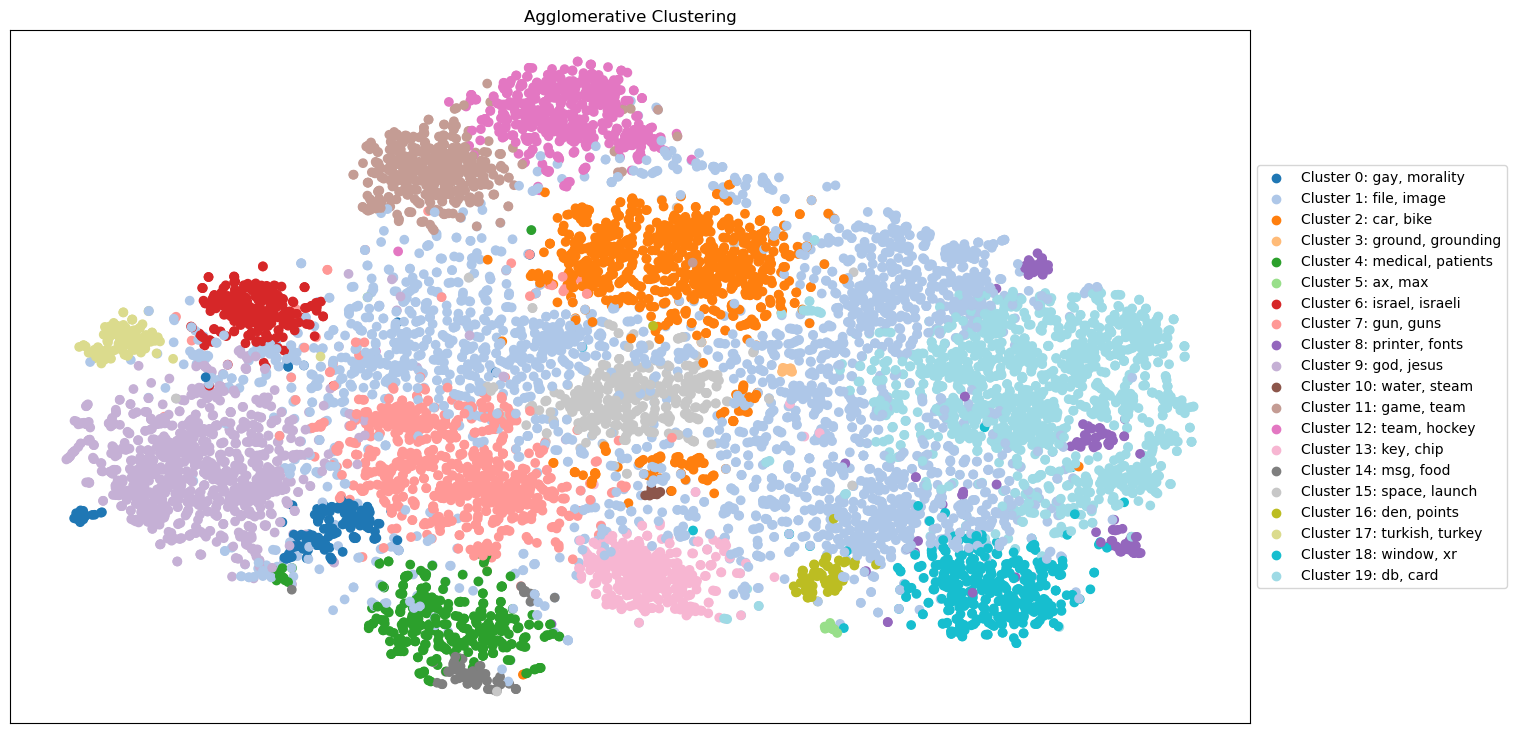

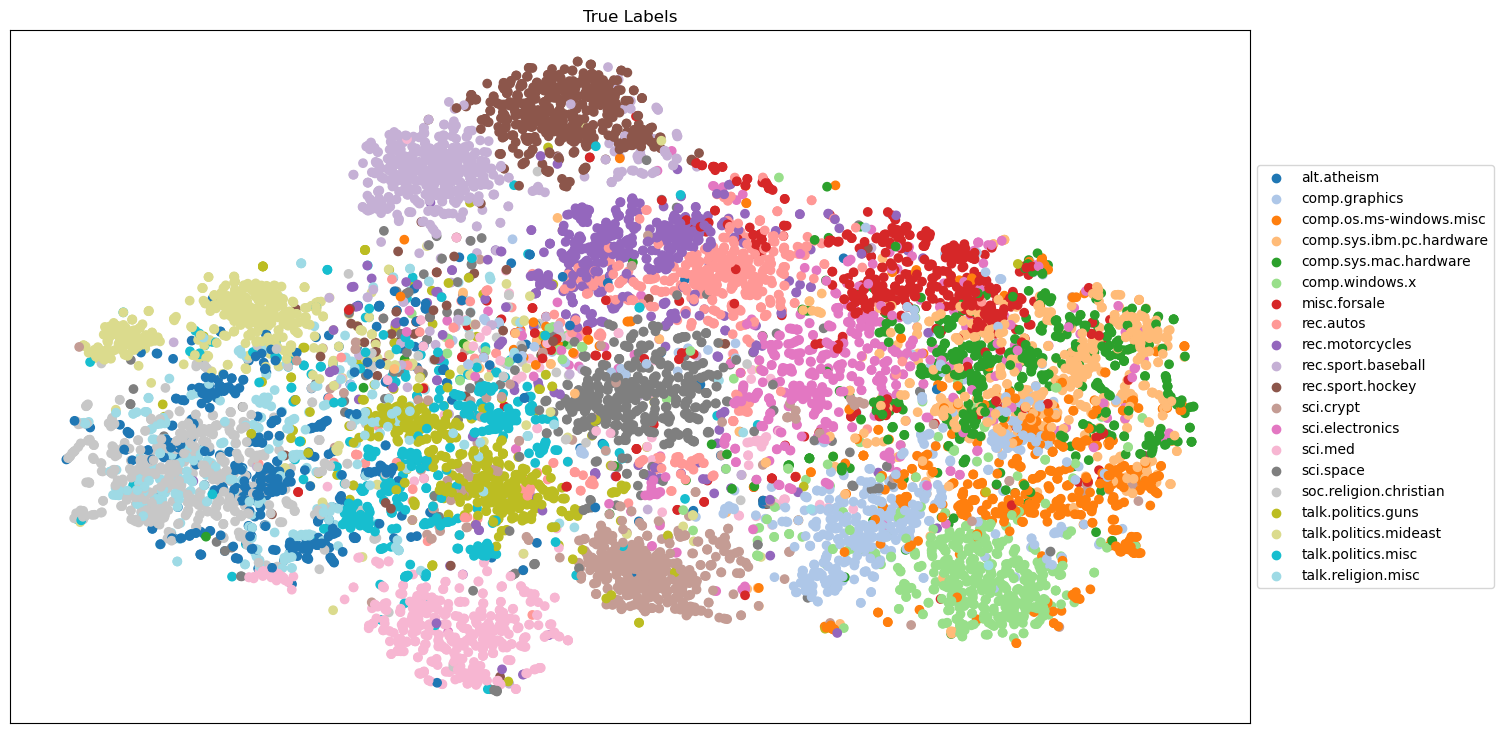

In [21]:
plt.figure(figsize=(16, 9))
plt.title("Agglomerative Clustering")
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=clustering.labels_, cmap='tab20')
plt.xticks([])
plt.yticks([])
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=f"Cluster {i}: {keywords[i][0]}, {keywords[i][1]}") for i in range(20)], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(16, 9))
plt.title("True Labels")
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=newsgroups_train.target, cmap='tab20')
plt.xticks([])
plt.yticks([])
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=newsgroups_train.target_names[i]) for i in range(20)], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We can now compare the generated topics (here represented as just the first word of the first topic, so a very poor summary) with the original labels. We can see that the topics are not perfect, but they are still pretty good. Expanding to use all topics generated for a cluster and somehow summarizing them would probably yield better results.

## Clustering Evaluation

We can also evaluate the clustering algorithm by comparing the original labels with the computed clusters. Both the completeness and homogeneity scores are around 0.5 ot 50%, which is reasonable for this dataset. The V-measure is a combination of both, and is also around 50%. This indicates that in general, around half of the articles in a cluster are from the same original label, and that half of the articles in a label are in the same cluster.

Spectral clustering seems to have a higher completeness, but a visual inspection shows that (at least in our opinion) the clusters are not as good as the ones generated by Agglomerative Clustering. This may be an artifact of the very big cluster generated by Spectral Clustering, which make it so that some labels are all in the same cluster (the big one) increasing the completeness score.

In [15]:
from sklearn.metrics import homogeneity_completeness_v_measure

print("Homogeneity, Completeness, V-measure for KMeans: ", homogeneity_completeness_v_measure(newsgroups_train.target, kmeans.labels_))
print("Homogeneity, Completeness, V-measure for Agglomerative: ", homogeneity_completeness_v_measure(newsgroups_train.target, agg.labels_))
print("Homogeneity, Completeness, V-measure for Spectral: ", homogeneity_completeness_v_measure(newsgroups_train.target, spectral.labels_))

Homogeneity, Completeness, V-measure for KMeans:  (0.512194759053307, 0.5206933162581903, 0.516409074780152)
Homogeneity, Completeness, V-measure for Agglomerative:  (0.5167756327104035, 0.5354613319688668, 0.5259525713478633)
Homogeneity, Completeness, V-measure for Spectral:  (0.5094430392595242, 0.6277177469572723, 0.5624295889958474)
